# IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fpdf import FPDF
import seaborn as sns
import numpy as np

# FETCHING THE DATA

In [2]:
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

In [3]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')

In [ ]:
transaction_data.head()

In [ ]:
transaction_data.info()

# DATA CLEANING

### converting date column to datetime

In [ ]:
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

In [ ]:
transaction_data.info()

### merging the data

In [ ]:
merged_data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR')

### finding outliers

In [ ]:
numerical_cols = merged_data.select_dtypes(include=[np.number]).columns

In [ ]:
outlier_columns = {}

for col in numerical_cols:
    Q1 = merged_data[col].quantile(0.25)
    Q3 = merged_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = merged_data[(merged_data[col] < lower_bound) | (merged_data[col] > upper_bound)]
    
    if not outliers.empty:
        outlier_columns[col] = len(outliers)

In [ ]:
for col, count in outlier_columns.items():
    print(f'{col}: {count} outliers')

### removing outliers

In [ ]:
columns_to_check = ['PROD_QTY', 'TOT_SALES']

In [ ]:
for col in columns_to_check:
    Q1 = transaction_data[col].quantile(0.25)
    Q3 = transaction_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    transaction_data = transaction_data[(transaction_data[col] >= lower_bound) & (transaction_data[col] <= upper_bound)]

### merging cleaned data again

In [ ]:
cleaned_merged_data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR')

# PERFORMING THE BASIC CHECKS

In [144]:
cleaned_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236039 entries, 0 to 236038
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              236039 non-null  datetime64[ns]
 1   STORE_NBR         236039 non-null  int64         
 2   LYLTY_CARD_NBR    236039 non-null  int64         
 3   TXN_ID            236039 non-null  int64         
 4   PROD_NBR          236039 non-null  int64         
 5   PROD_NAME         236039 non-null  object        
 6   PROD_QTY          236039 non-null  int64         
 7   TOT_SALES         236039 non-null  float64       
 8   LIFESTAGE         236039 non-null  object        
 9   PREMIUM_CUSTOMER  236039 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 18.0+ MB


In [145]:
cleaned_merged_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [146]:
cleaned_merged_data.duplicated().sum()

1

In [147]:
cleaned_merged_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,236039,236039.000000,2.360390e+05,2.360390e+05,236039.000000,236039.0,236039.000000
mean,2018-12-29 23:36:19.394082816,135.216896,1.356215e+05,1.353046e+05,56.553413,2.0,7.675745
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,2.0,2.700000
25%,2018-10-03 00:00:00,70.000000,7.009200e+04,6.801950e+04,28.000000,2.0,6.000000
50%,2018-12-30 00:00:00,130.000000,1.301860e+05,1.344130e+05,56.000000,2.0,7.600000
75%,2019-03-28 00:00:00,203.000000,2.031780e+05,2.030145e+05,85.000000,2.0,9.200000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,2.0,13.000000
std,NaN,76.239687,7.923836e+04,7.763394e+04,32.821531,0.0,2.215834


# PERFORMING EDA

### visualizing sales distribution ( histplot )

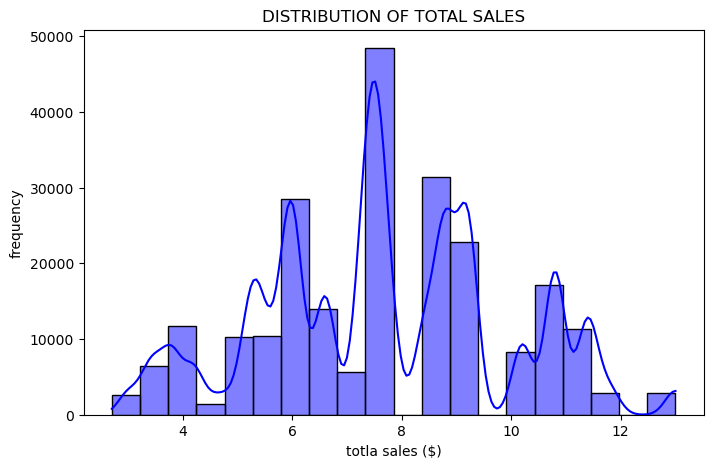

In [148]:
plt.figure(figsize=(8,5))
sns.histplot(transaction_data['TOT_SALES'], bins=20, kde=True, color='blue')
plt.title('DISTRIBUTION OF TOTAL SALES')
plt.xlabel('totla sales ($)')
plt.ylabel('frequency')
plt.show()

### total sales by customer segment

In [149]:
sales_by_segment = cleaned_merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().unstack()

### visualizing total sales by customer segment ( bar chart )

<Figure size 1200x600 with 0 Axes>

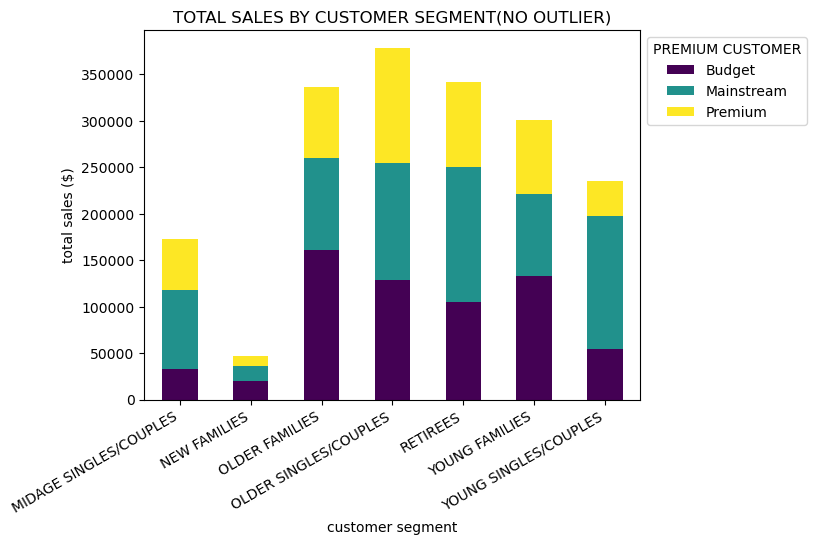

In [150]:
plt.figure(figsize=(12,6))
sales_by_segment.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('TOTAL SALES BY CUSTOMER SEGMENT(NO OUTLIER)')
plt.xlabel('customer segment')
plt.ylabel('total sales ($)')
plt.xticks(rotation=30, ha='right') # aligning x axis labels properly
plt.legend(title='PREMIUM CUSTOMER', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout
plt.show()

### sorting LIFESTAGE categories based on average pack size

In [151]:
cleaned_merged_data["PACK_SIZE"] = cleaned_merged_data["PROD_NAME"].str.extract(r'(\d{2,3})')[0].astype(float)

### visualizing avg pack size preference ( box plot )

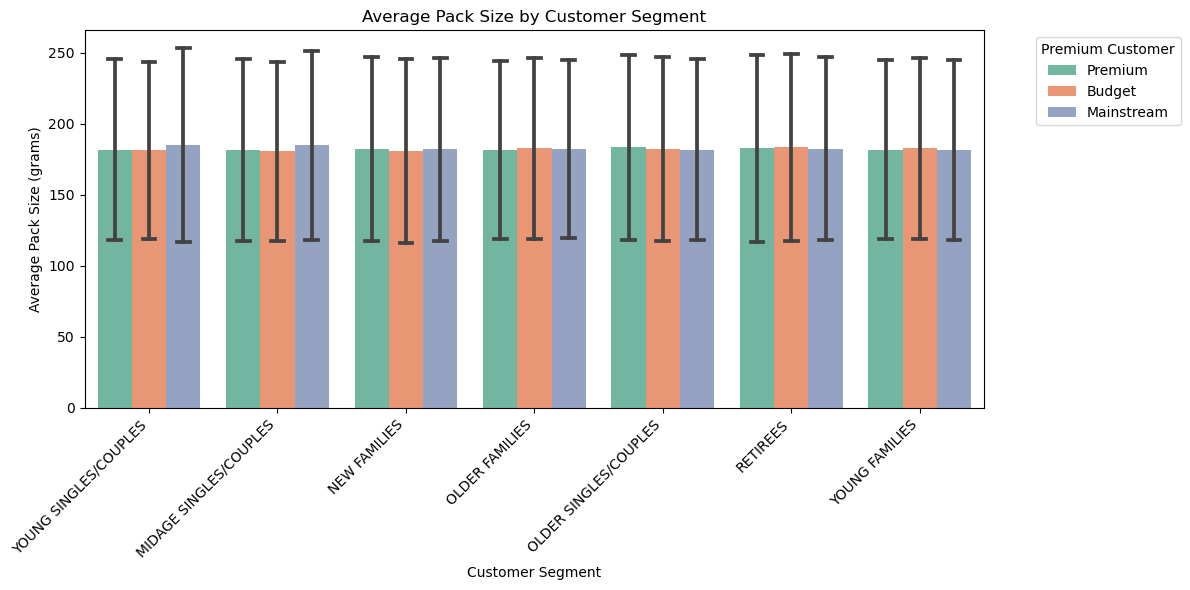

In [152]:
plt.figure(figsize=(12, 6))
sns.barplot(x="LIFESTAGE", y="PACK_SIZE", hue="PREMIUM_CUSTOMER", data=cleaned_merged_data, errorbar="sd", capsize=0.1)
plt.title("Average Pack Size by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Pack Size (grams)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Premium Customer", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### extracting BRAND_NAME

In [154]:
cleaned_merged_data['BRAND_NAME'] = cleaned_merged_data['PROD_NAME'].str.split().str[0]

### identifying top selling chip brands

In [156]:
top_brands = cleaned_merged_data['BRAND_NAME'].value_counts().head(10)

### visualizing top selling chip brands ( pie chart )

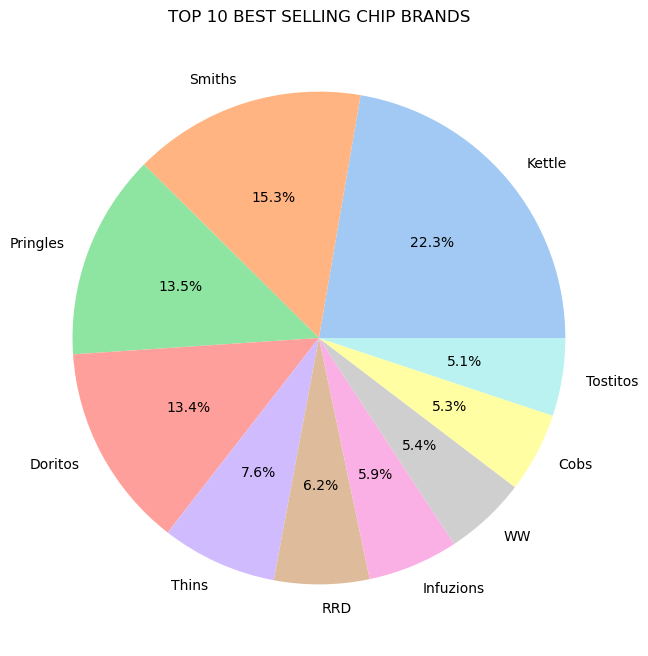

In [157]:
plt.figure(figsize=(8,8))
plt.pie(top_brands, labels=top_brands.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('TOP 10 BEST SELLING CHIP BRANDS')
plt.show()

### deep diving into customer spending behavior

In [158]:
avg_spend = cleaned_merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].mean().unstack()

### visualizing avg spend  ( heatmap )

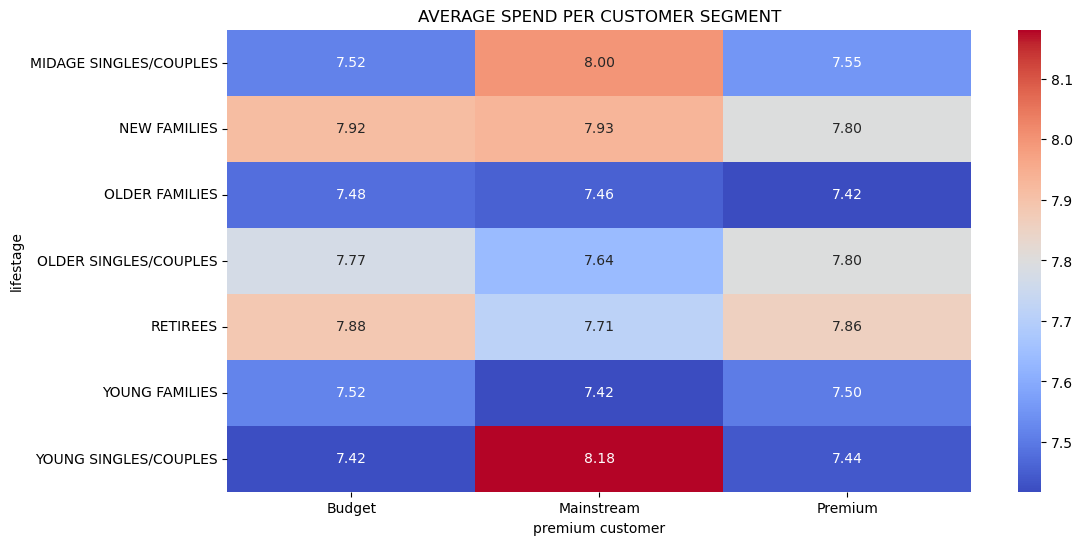

In [159]:
plt.figure(figsize=(12,6))
sns.heatmap(avg_spend, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('AVERAGE SPEND PER CUSTOMER SEGMENT')
plt.xlabel('premium customer')
plt.ylabel('lifestage')
plt.show()

### time-based sales analysis

In [160]:
cleaned_merged_data['WEEKDAY'] = cleaned_merged_data['DATE'].dt.day_name()
weekday_sales = cleaned_merged_data.groupby('WEEKDAY')['TOT_SALES'].sum()

### visualizing time-based sales analysis ( line chart )

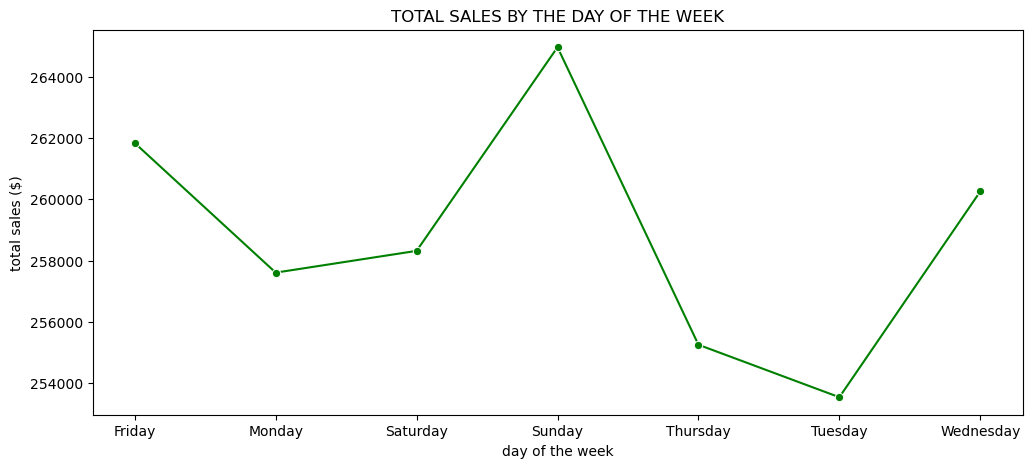

In [161]:
plt.figure(figsize=(12,5))
sns.lineplot(x=weekday_sales.index, y=weekday_sales.values, marker='o', color='green')
plt.title('TOTAL SALES BY THE DAY OF THE WEEK')
plt.xlabel('day of the week')
plt.ylabel('total sales ($)')
plt.xticks(rotation=0)
plt.show()

# KEY INSIGHTS AND RECOMMENDATIONS

In [162]:
print("Key Insights:")
print("- Older Families, Retirees, and Older Singles/Couples are the top-spending groups.")
print("- Budget and Mainstream customers contribute the most to total sales.")
print("- Most customers prefer ~181-184g packs.")
print("- Kettle, Smiths, and Pringles are the most purchased brands.")
print("- Premium brands (e.g., Kettle, RRD) also perform well, indicating demand for high-quality chips.")
print("- Customers in the premium segment have a higher average spend per transaction.")
print("- Sales peak on weekends, suggesting higher demand during leisure time.")

Key Insights:
- Older Families, Retirees, and Older Singles/Couples are the top-spending groups.
- Budget and Mainstream customers contribute the most to total sales.
- Most customers prefer ~181-184g packs.
- Kettle, Smiths, and Pringles are the most purchased brands.
- Premium brands (e.g., Kettle, RRD) also perform well, indicating demand for high-quality chips.
- Customers in the premium segment have a higher average spend per transaction.
- Sales peak on weekends, suggesting higher demand during leisure time.


# NEXT STEPS

In [163]:
print("Next Steps:")
print("- Further analyze sales trends by day/month.")
print("- Identify promotional impacts on chip sales.")
print("- Provide targeted recommendations for increasing sales.")
print("- Study price sensitivity by comparing sales with discounts applied.")

Next Steps:
- Further analyze sales trends by day/month.
- Identify promotional impacts on chip sales.
- Provide targeted recommendations for increasing sales.
- Study price sensitivity by comparing sales with discounts applied.
